## Importando dependências

In [1]:
import numpy as np
import sys
import pandas as pd
from pandas import DataFrame
import tensorflow as tf
import matplotlib.pyplot as plt
import multiprocessing as mp
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.losses import Loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Binarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Importando dataset e splitando em teste e treino

In [2]:
def normalize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    unique_labels = sorted(list(set(y)))
    for i in range(len(y)):
        y[i] = unique_labels.index(y[i])
    dataset.iloc[:, -1] = y
    
def binarize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    binarizer = Binarizer()
    y = binarizer.fit_transform([y])[0]
    dataset.iloc[:, -1] = y
    

HEADER = ["timestamp",'srcip', 'srcport', 'dstip', 'dstport', 'proto', 'total_fpackets', 'total_fvolume',
          'total_bpackets', 'total_bvolume', 'min_fpktl', 'mean_fpktl', 'max_fpktl', 'std_fpktl', 'min_bpktl',
          'mean_bpktl', 'max_bpktl', 'std_bpktl', 'min_fiat', 'mean_fiat', 'max_fiat', 'std_fiat', 'min_biat',
          'mean_biat', 'max_biat', 'std_biat', 'duration', 'min_active', 'mean_active', 'max_active', 'std_active',
          'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'sflow_fpackets', 'sflow_fbytes', 'sflow_bpackets',
          'sflow_bbytes', 'fpsh_cnt', 'bpsh_cnt', 'furg_cnt', 'burg_cnt', 'total_fhlen', 'total_bhlen', "dscp", 'class']
initial_dataset_02_24 = pd.read_csv('dataset-oi-2017-02-24-summarized.csv', names=HEADER)
initial_dataset_02_25 = pd.read_csv('dataset-oi-2017-02-25-summarized.csv', names=HEADER)
initial_dataset_02_26 = pd.read_csv('dataset-oi-2017-02-26-summarized.csv', names=HEADER)
# initial_dataset_02_27 = pd.read_csv('dataset-oi-2017-02-27-summarized.csv', names=HEADER)
# initial_dataset_02_28 = pd.read_csv('dataset-oi-2017-02-28-summarized.csv', names=HEADER)

initial_dataset_02_24 = initial_dataset_02_24.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_25 = initial_dataset_02_25.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_26 = initial_dataset_02_26.replace([np.inf, -np.inf], np.nan).dropna()
# initial_dataset_02_27 = initial_dataset_02_27.replace([np.inf, -np.inf], np.nan).dropna()
# initial_dataset_02_28 = initial_dataset_02_28.replace([np.inf, -np.inf], np.nan).dropna()

initial_dataset = initial_dataset_02_24.append(initial_dataset_02_25, ignore_index=True)
initial_dataset = initial_dataset.append(initial_dataset_02_26, ignore_index=True)
# initial_dataset = initial_dataset.append(initial_dataset_02_27, ignore_index=True)
# initial_dataset = initial_dataset.append(initial_dataset_02_28, ignore_index=True)

binarize_dataset_labels(initial_dataset)

## Criando modelo do cliente

In [3]:
class Client:
    def __init__(self, client_id = 123, dataset = DataFrame(list())):
        self.client_id = client_id
        self.local_dataset = dataset
        self.local_decision_tree = DecisionTreeClassifier(max_depth=20, criterion='entropy')
        self.metrics_history = list()
        self.local_forest_set = [self.local_decision_tree]
        
    def apply_oversample(self, X, y):
        labels_counts = self.local_dataset['class'].value_counts()
        target_label = labels_counts.keys()[1]
        max_samples = int(labels_counts.values[0] * 0.6)
        current_samples = labels_counts.values[1]
        
        if current_samples >= max_samples:
            return X, y
        
        smote_oversample = SMOTE(sampling_strategy={target_label: max_samples}, random_state=0)
        return smote_oversample.fit_resample(X, y)

        
    def preprocess(self):
        X = self.local_dataset.iloc[:, 5:-1].values
        y = self.local_dataset.iloc[:, -1].values

#         X, y = self.apply_oversample(X, y)
                
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)        
        
    def train_local_forest(self):
        # depth 35 é o melhor aplicando grid seach
        self.local_decision_tree.fit(self.X_train, self.y_train)
        
    def test_local_forest(self):
        y_pred = self.local_decision_tree.predict(self.X_test)
        
        self.local_decision_tree_prec = precision_score(self.y_test, y_pred)
        self.local_decision_tree_rec =recall_score(self.y_test, y_pred)
        self.local_decision_tree_f1 = f1_score(self.y_test, y_pred)
        
        self.local_decision_tree_acc = self.local_decision_tree.score(self.X_test, self.y_test)
        print(f"[INFO] Accuracy of client {self.client_id} tree = {self.local_decision_tree_acc}")
        
        cm = confusion_matrix(self.y_test, y_pred)
        print(cm)  

## Splitando dataset para os clientes participantes

In [4]:
def split_dataset_non_iid(clients):
    unique_ips = initial_dataset['srcip'].value_counts().head(num_clients + 10).keys()
    client_index, srcip = (0,0)
    while client_index < num_clients:
        local_dataset = initial_dataset.loc[initial_dataset['srcip'] == unique_ips[srcip]]
        num_classes = len(local_dataset['class'].value_counts())
        if num_classes > 1:
            print(f"values counts for client {client_index} = {local_dataset['class'].value_counts()}")
            clients[client_index].local_dataset = local_dataset
            client_index += 1
        srcip += 1

        
        
num_clients = 20
max_num_trees = 10
clients = [Client(client_id = i) for i in range(num_clients)]  

split_dataset_non_iid(clients)

values counts for client 0 = 0.0    706880
1.0     89679
Name: class, dtype: int64
values counts for client 1 = 0.0    475434
1.0    194275
Name: class, dtype: int64
values counts for client 2 = 0.0    450627
1.0        85
Name: class, dtype: int64
values counts for client 3 = 0.0    162815
1.0    123410
Name: class, dtype: int64
values counts for client 4 = 1.0    146303
0.0    109088
Name: class, dtype: int64
values counts for client 5 = 0.0    185126
1.0     14536
Name: class, dtype: int64
values counts for client 6 = 0.0    109697
1.0     32381
Name: class, dtype: int64
values counts for client 7 = 0.0    132126
1.0      1612
Name: class, dtype: int64
values counts for client 8 = 0.0    124972
1.0       272
Name: class, dtype: int64
values counts for client 9 = 0.0    122483
1.0        55
Name: class, dtype: int64
values counts for client 10 = 0.0    111212
1.0      9173
Name: class, dtype: int64
values counts for client 11 = 1.0    61001
0.0    48522
Name: class, dtype: int64
valu

## Treinando e testando modelos RF locais

In [5]:
for client in clients:
    client.preprocess()
    client.train_local_forest()
    client.test_local_forest()

print("[INFO] All local trains are finished!")

[INFO] Accuracy of client 0 tree = 0.9375878778748619
[[138827   2387]
 [  7556  10542]]
[INFO] Accuracy of client 1 tree = 0.8316734108793359
[[87297  7806]
 [14740 24099]]
[INFO] Accuracy of client 2 tree = 0.999911252121629
[[90126     1]
 [    7     9]]
[INFO] Accuracy of client 3 tree = 0.8182199318717792
[[29819  2574]
 [ 7832 17020]]
[INFO] Accuracy of client 4 tree = 0.8658156972532743
[[17669  4294]
 [ 2560 26556]]
[INFO] Accuracy of client 5 tree = 0.998046728269852
[[36927    46]
 [   32  2928]]
[INFO] Accuracy of client 6 tree = 0.9517877252252253
[[20851  1096]
 [  274  6195]]
[INFO] Accuracy of client 7 tree = 0.9977942276058023
[[26400    18]
 [   41   289]]
[INFO] Accuracy of client 8 tree = 0.9992414866860952
[[24977    10]
 [    9    53]]
[INFO] Accuracy of client 9 tree = 0.9997959849844948
[[24491     1]
 [    4    12]]
[INFO] Accuracy of client 10 tree = 0.958217385886946
[[22125    87]
 [  919   946]]
[INFO] Accuracy of client 11 tree = 0.8530472494864186
[[ 7529 

## Compartilhando RFs e atualizando o conjunto de RFs


In [6]:
import random
for current in range(num_clients):
    appended_trees, replaced_trees, acc_list = (0,0,[])
    print(f"Starting sharing for client {current}")
    for neighbour in range(num_clients):
        if current != neighbour:
            neighbour_tree = clients[neighbour].local_decision_tree
            acc = neighbour_tree.score(clients[current].X_test, clients[current].y_test)
            
            if len(clients[current].local_forest_set) <= max_num_trees:
                clients[current].local_forest_set.append(neighbour_tree)
                acc_list.append(acc)
                appended_trees += 1
            else:
                min_acc = min(acc_list)
                min_index = acc_list.index(min_acc) # seleciona a árvore de menor acurácia
#                 min_index = random.randint(0,max_num_trees-1) # seleciona uma árvore aleatória
                if min_acc < acc:
                    clients[current].local_forest_set[min_index] = neighbour_tree # substitui a árvore pela nova
                    acc_list[min_index] = acc
                    replaced_trees += 1
    print(f"Client {current} appended {appended_trees} and replaced {replaced_trees} trees to forest")
    print(f"{acc_list}\n")
                

Starting sharing for client 0
Client 0 appended 10 and replaced 8 trees to forest
[0.8742279300994276, 0.8697022195440394, 0.8864617856784172, 0.8806492919554083, 0.883191473335342, 0.8804484282414382, 0.8617178869137291, 0.8851687255197349, 0.8845912423420709, 0.8873593954002209]

Starting sharing for client 1
Client 1 appended 10 and replaced 7 trees to forest
[0.7399844708903854, 0.7491003568708844, 0.7782696988248645, 0.709874423257828, 0.7542369085126398, 0.7486300040315957, 0.7088739902345792, 0.7102850487524451, 0.7088665243164952, 0.7685789371519016]

Starting sharing for client 2
Client 2 appended 10 and replaced 8 trees to forest
[0.9993011104578281, 0.9994786062145702, 0.9998114107584616, 0.9994896996993665, 0.9986687818244345, 0.9996117280321267, 0.9970824134985523, 0.9996117280321267, 0.9991458016706788, 0.9988019036419911]

Starting sharing for client 3
Client 3 appended 10 and replaced 8 trees to forest
[0.5964713075377762, 0.7236789239234868, 0.5708271464756748, 0.72500

## Testando o conjunto de RF dos clientes

In [7]:
# import statistics
# from statistics import mode

# def forest_predict(forest, X):
#     forest_prediction = list()
#     for row in X:
#         tree_predictions = list()
#         for tree in forest:
#             tree_predictions.append(tree.predict([row])[0])
#         forest_prediction.append(mode(tree_predictions))
#     return forest_prediction

# for client in clients:
#     accuracy = Accuracy()
#     forest_pred = forest_predict(client.local_forest_set, client.X_test)
#     accuracy.update_state(client.y_test, forest_pred)
#     acc = accuracy.result().numpy()
#     client.local_forest_set_acc = acc
    
#     print(f"[INFO] Accuracy of client {client.client_id} forest = {acc}")

In [8]:
from statistics import mode

def tree_predict(tree, row):
    return tree.predict([row])[0]

def forest_predict(forest, X):
    forest_prediction = list()
    pool = mp.Pool(mp.cpu_count())
    for row in X:        
        tree_predictions = pool.starmap(tree_predict, [(tree, row) for tree in forest])
        forest_prediction.append(mode(tree_predictions))
    return forest_prediction

for client in clients:
    accuracy = Accuracy()
    forest_pred = forest_predict(client.local_forest_set, client.X_test)
    accuracy.update_state(client.y_test, forest_pred)
    acc = accuracy.result().numpy()
    client.local_forest_set_acc = acc

    print(f"[INFO] Accuracy of client {client.client_id} forest = {acc}")

[INFO] Accuracy of client 0 forest = 0.8863990306854248
[INFO] Accuracy of client 1 forest = 0.7101207971572876
[INFO] Accuracy of client 2 forest = 0.9998224973678589
[INFO] Accuracy of client 3 forest = 0.599895179271698
[INFO] Accuracy of client 4 forest = 0.49127820134162903
[INFO] Accuracy of client 5 forest = 0.9258758425712585
[INFO] Accuracy of client 6 forest = 0.772346556186676
[INFO] Accuracy of client 7 forest = 0.9876626133918762
[INFO] Accuracy of client 8 forest = 0.9975248575210571
[INFO] Accuracy of client 9 forest = 0.9993471503257751
[INFO] Accuracy of client 10 forest = 0.9225401878356934
[INFO] Accuracy of client 11 forest = 0.47961652278900146
[INFO] Accuracy of client 12 forest = 0.9997692108154297
[INFO] Accuracy of client 13 forest = 0.9831607937812805
[INFO] Accuracy of client 14 forest = 0.9975845217704773
[INFO] Accuracy of client 15 forest = 0.9997627139091492
[INFO] Accuracy of client 16 forest = 0.9396252036094666
[INFO] Accuracy of client 17 forest = 0.8

## Plotando resultados dos treinos locais

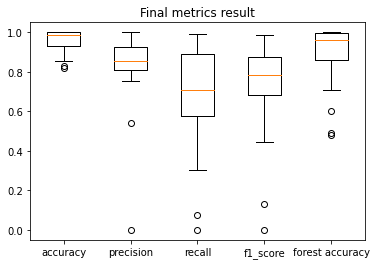

In [9]:
final_metrics = [[], [], [], [], []]
for client in clients:
    final_metrics[0].append(client.local_decision_tree_acc)
    final_metrics[1].append(client.local_decision_tree_prec)
    final_metrics[2].append(client.local_decision_tree_rec)
    final_metrics[3].append(client.local_decision_tree_f1)
    final_metrics[4].append(client.local_forest_set_acc)

plt.boxplot(final_metrics)
plt.title('Final metrics result')
plt.xticks([1, 2, 3, 4, 5], ['accuracy', 'precision', 'recall', 'f1_score', 'forest accuracy'])
plt.show()